In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tabulate import tabulate
from io import StringIO

C:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('EDA-Fase3.csv')
df.head()

,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,...,Prefecture_shizuoka prefecture,Prefecture_tochigi prefecture,Prefecture_tokushima prefecture,Prefecture_tokyo,Prefecture_tottori prefecture,Prefecture_toyama prefecture,Prefecture_wakayama prefecture,Prefecture_yamagata prefecture,Prefecture_yamaguchi prefecture,Prefecture_yamanashi prefecture
0,15.00000,15.00000,50000000,330,False,150000.000000,19.5,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0
1,29.87038,29.87038,32000000,200,False,157124.851993,NaN,False,120.0,False,...,0,0,0,0,0,0,0,0,0,0
2,16.00000,16.00000,37000000,180,False,201861.789019,13.4,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
3,5.00000,5.00000,35000000,190,False,180900.323019,12.0,False,115.0,False,...,0,0,0,0,0,0,0,0,0,0
4,120.00000,120.00000,380000,195,False,1900.000000,17.4,False,NaN,False,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns.tolist()

['MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandShape_semi-square shaped',
 'LandShape_semi-trapezoidal shaped',
 'LandShape_square shaped',

Has the price of real estate in Japan increased/decreased in the last 10 years? (residential use)

In [4]:
#1 Filter data by year and residential  'Type_residential land(land and building)' or  'Type_residential land(land only)',
# last year is 2019, so last ten year is >= 2009
filtered_df = df[(df['Year'] >= 2009)]
filtered_df = filtered_df[(filtered_df['Type_residential land(land and building)'] == 1) | (filtered_df['Type_residential land(land only)'] == 1)]
#2 group by year and get mean
price_trend = filtered_df.groupby("Year")["TradePrice"].mean().reset_index()

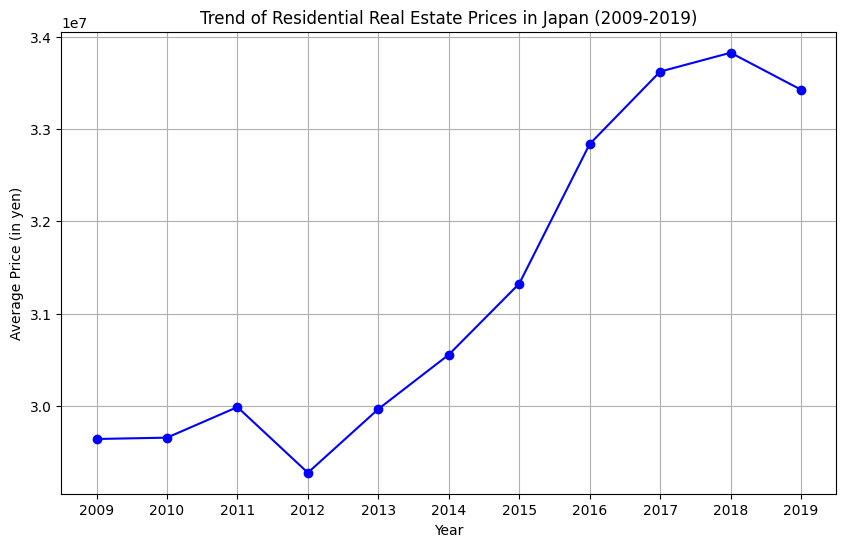

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(price_trend["Year"], price_trend["TradePrice"], marker='o', linestyle='-', color='b')
plt.title("Trend of Residential Real Estate Prices in Japan (2009-2019)")
plt.xlabel("Year")
plt.ylabel("Average Price (in yen)")
plt.xticks(price_trend["Year"])  
plt.grid()
plt.show()

Is there a price difference between Tokyo(Capital of Japan) and local areas?
the analysis will show comparations between Tokyo municipalities/wards inside Tokyo prefecture in 2019

In [6]:
df_tokyo = df[(df['Year'] == 2019) & (df['Prefecture_tokyo'] == 1)]

df_tokyo = df_tokyo.groupby("Municipality_M")["TradePrice"].mean().reset_index()
df_tokyo = df_tokyo.sort_values(by="TradePrice")

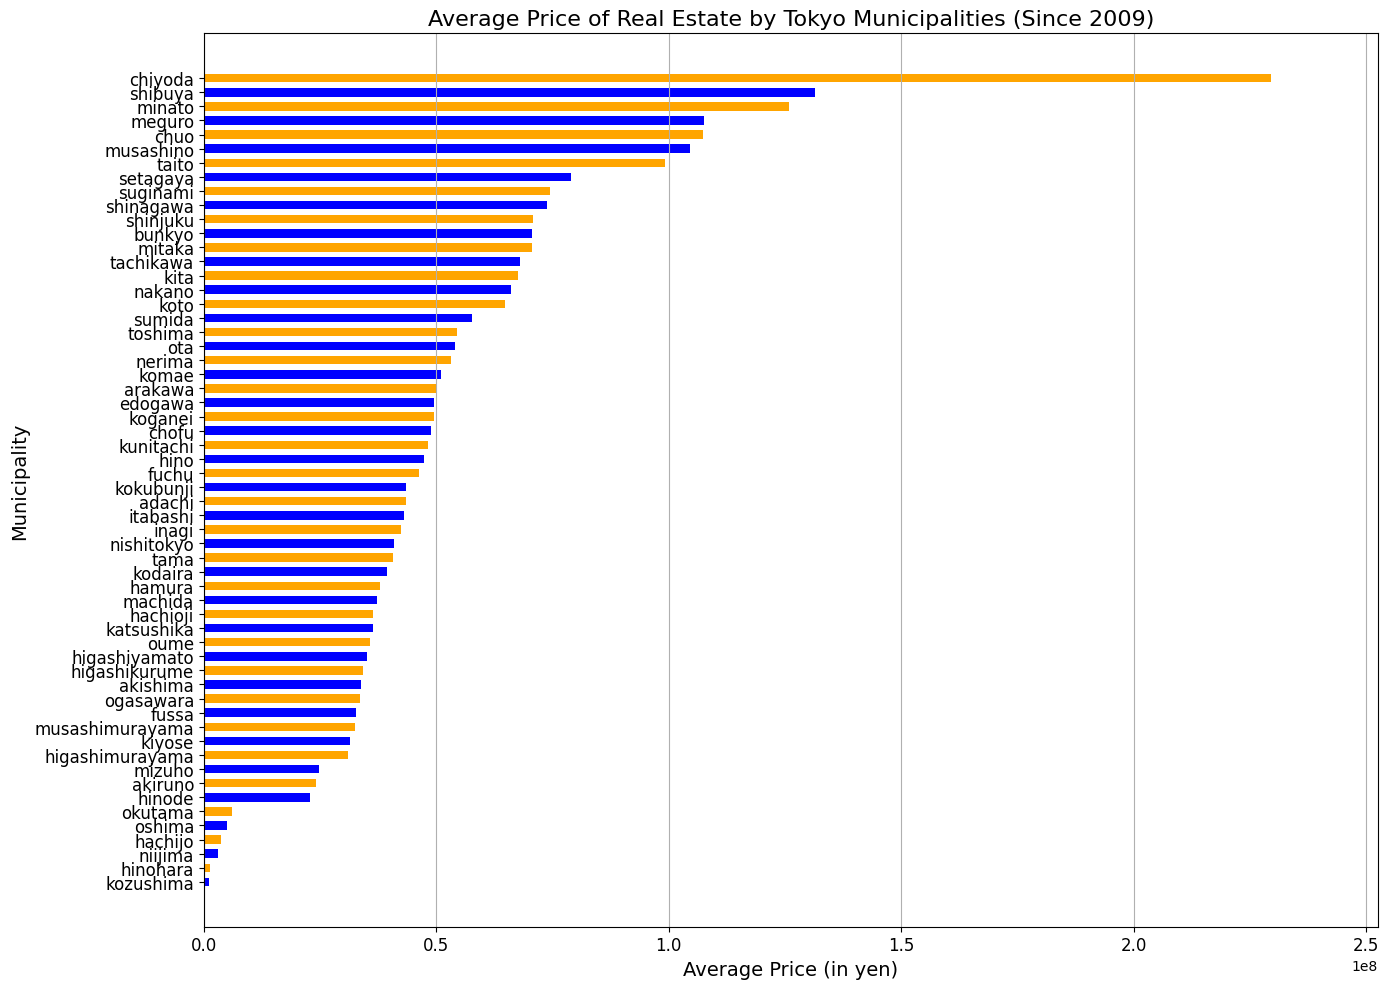

In [7]:
plt.figure(figsize=(14, 10))  
plt.barh(df_tokyo["Municipality_M"], df_tokyo["TradePrice"], color=['blue', 'orange'], height=0.6) 
plt.title("Average Price of Real Estate by Tokyo Municipalities (Since 2009)", fontsize=16)
plt.xlabel("Average Price (in yen)", fontsize=14)
plt.ylabel("Municipality", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xlim(0, df_tokyo["TradePrice"].max() * 1.1) 
plt.grid(axis='x')
plt.tight_layout()  
plt.show()

A comparacion of prefectures prices is done

In [8]:
df_19 = df[(df['Year'] == 2019)]
prefecture_columns = [col for col in df_19.columns if col.startswith('Prefecture')]


In [9]:
df_19.columns

Index(['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'TradePrice',
       'Area', 'AreaIsGreaterFlag', 'UnitPrice', 'Frontage',
       'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag',
       ...
       'Prefecture_shizuoka prefecture', 'Prefecture_tochigi prefecture',
       'Prefecture_tokushima prefecture', 'Prefecture_tokyo',
       'Prefecture_tottori prefecture', 'Prefecture_toyama prefecture',
       'Prefecture_wakayama prefecture', 'Prefecture_yamagata prefecture',
       'Prefecture_yamaguchi prefecture', 'Prefecture_yamanashi prefecture'],
      dtype='object', length=167)

In [10]:
print(tabulate(df_19[prefecture_columns].head(), headers='keys', tablefmt='psql'))


+---------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+-------------------------------+-------------------------------+---------------------------------+-----------------------------------+------------------------------+-------------------------------+-----------------------------------+-----------------------+-------------------------------+---------------------------------+----------------------------------+-------------------------------+--------------------------------+-----------------------------------+----------------------------------+-------------------------------+----------------------------------+-------------------------------+-----------------------------+--------------------------------+----------------------------------+--------------------------------+----------------------------------+------------------------------+---------------------------------+------------------------------+-----

In [11]:
#reverting get dummies changes
df_19['Prefecture'] = df_19[prefecture_columns].idxmax(axis=1)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8096\1254496399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19['Prefecture'] = df_19[prefecture_columns].idxmax(axis=1)


In [12]:
df_19.head()

,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,TotalFloorAreaIsGreaterFlag,...,Prefecture_tochigi prefecture,Prefecture_tokushima prefecture,Prefecture_tokyo,Prefecture_tottori prefecture,Prefecture_toyama prefecture,Prefecture_wakayama prefecture,Prefecture_yamagata prefecture,Prefecture_yamaguchi prefecture,Prefecture_yamanashi prefecture,Prefecture
3707182,5.0,5.0,190000000,270,False,691058.376823,11.0,False,1100.0,False,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
3707183,5.0,5.0,23000000,65,False,347487.653447,NaN,False,NaN,False,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
3707184,2.0,2.0,11000000,40,False,270058.339364,NaN,False,NaN,False,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
3707185,2.0,2.0,10000000,45,False,218228.961102,NaN,False,NaN,False,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
3707186,8.0,8.0,20000000,80,False,245507.581240,NaN,False,NaN,False,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido


In [13]:
df_prefecture = df_19[['Prefecture',"TradePrice"]]

In [14]:
df_prefecture.head()

,Prefecture,TradePrice
3707182,Prefecture_hokkaido,190000000
3707183,Prefecture_hokkaido,23000000
3707184,Prefecture_hokkaido,11000000
3707185,Prefecture_hokkaido,10000000
3707186,Prefecture_hokkaido,20000000


In [15]:
df_prefecture['Prefecture'] = df_prefecture['Prefecture'].str.replace('Prefecture_', '')

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8096\2610805386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prefecture['Prefecture'] = df_prefecture['Prefecture'].str.replace('Prefecture_', '')


In [16]:
df_prefecture.head()

,Prefecture,TradePrice
3707182,hokkaido,190000000
3707183,hokkaido,23000000
3707184,hokkaido,11000000
3707185,hokkaido,10000000
3707186,hokkaido,20000000


In [17]:
df_prefecture = df_prefecture.groupby("Prefecture")["TradePrice"].mean().reset_index()

In [18]:
df_prefecture.head(20)

,Prefecture,TradePrice
0,aichi prefecture,3.683196e+07
1,akita prefecture,9.519038e+06
2,aomori prefecture,8.507595e+06
3,chiba prefecture,2.807302e+07
4,ehime prefecture,1.454925e+07
5,fukui prefecture,1.553502e+07
6,fukuoka prefecture,3.099932e+07
7,fukushima prefecture,1.411937e+07
8,gifu prefecture,1.393635e+07
9,gunma prefecture,1.664651e+07


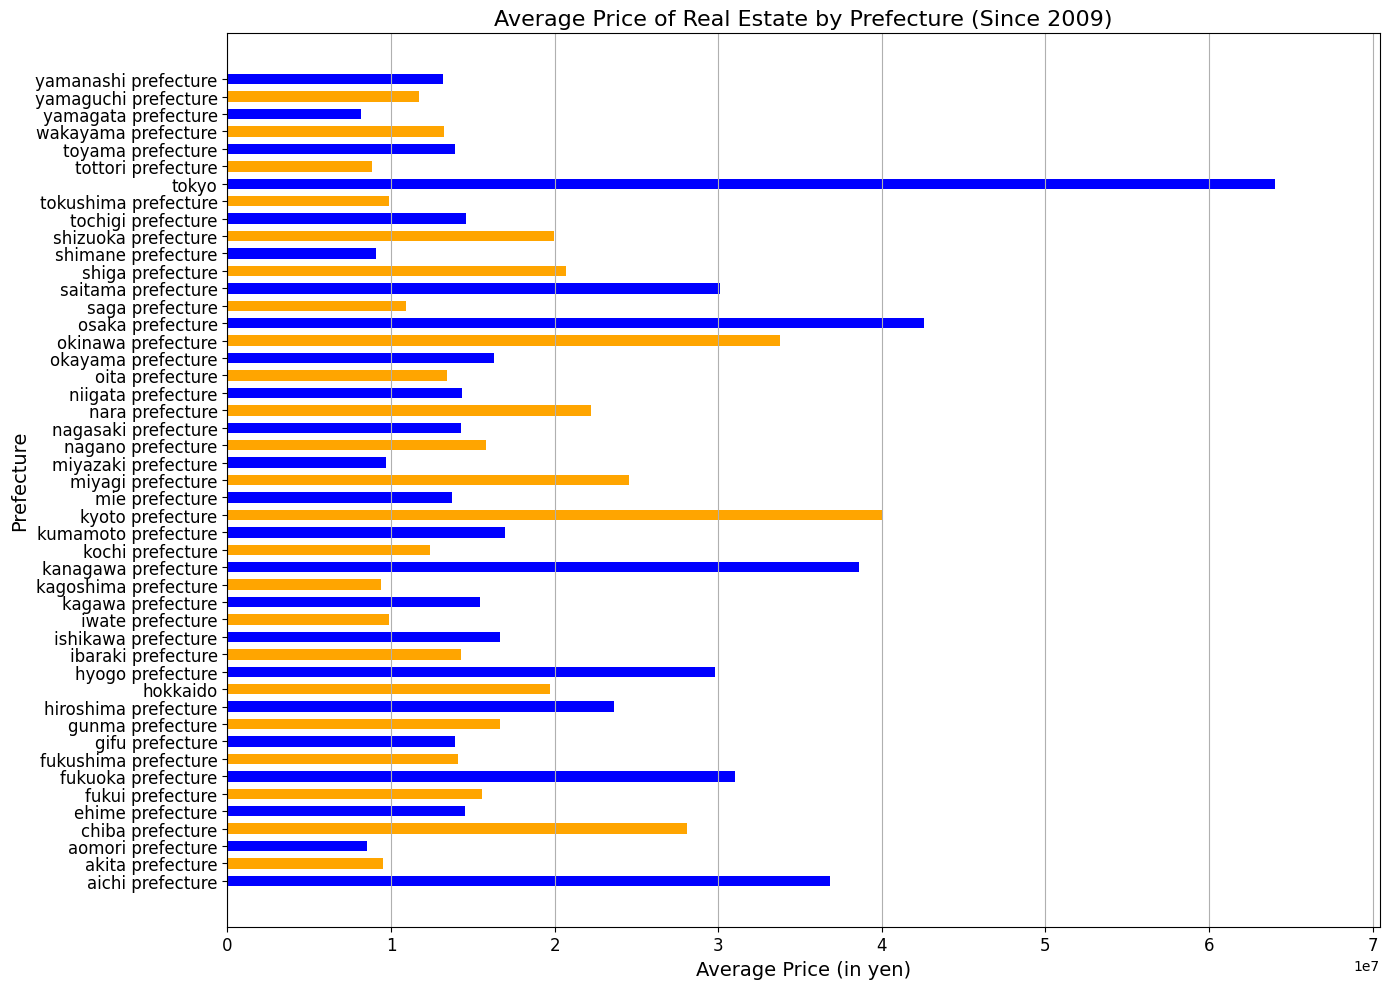

In [19]:
plt.figure(figsize=(14, 10))  
plt.barh(df_prefecture["Prefecture"], df_prefecture["TradePrice"], color=['blue', 'orange'], height=0.6) 
plt.title("Average Price of Real Estate by Prefecture (Since 2009)", fontsize=16)
plt.xlabel("Average Price (in yen)", fontsize=14)
plt.ylabel("Prefecture", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xlim(0, df_prefecture["TradePrice"].max() * 1.1) 
plt.grid(axis='x')
plt.tight_layout()  
plt.show()

Are there any duplicates?
Over the EDA has been found row duplicates and data redundancy in out data set. Check other jupyter notebook for reference.